In [3]:
%matplotlib notebook
import numpy as np
import finufft
import matplotlib.pyplot as plt
import scipy as sc

# Frequency spectra and moments from non-uniform samples


<IPython.core.display.Javascript object>


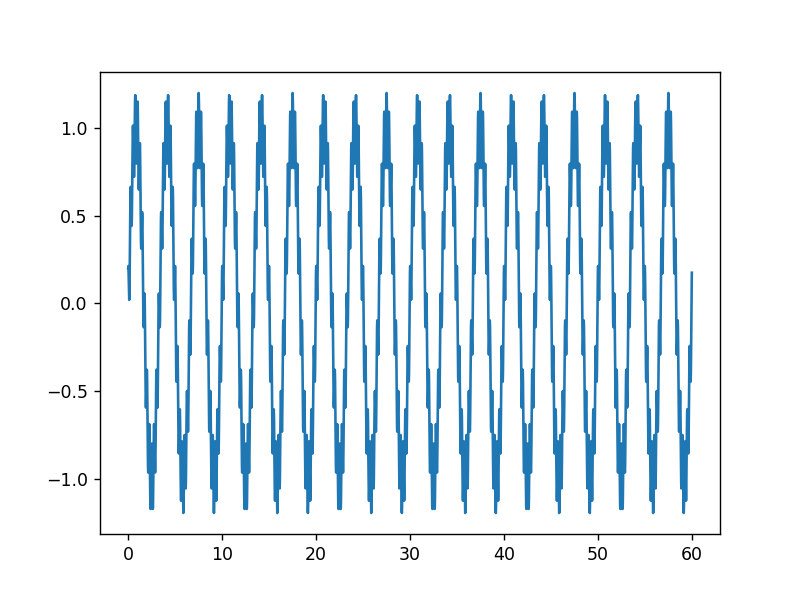

In [13]:
# Known synthetic data

dt = 0.01
Fs = 1 / dt
x = np.arange(0,60,0.01)
s = np.sin(0.3*2*np.pi*x) + 0.2 * np.cos(4*2*np.pi*x)

plt.figure()
plt.plot(x, s)

<IPython.core.display.Javascript object>


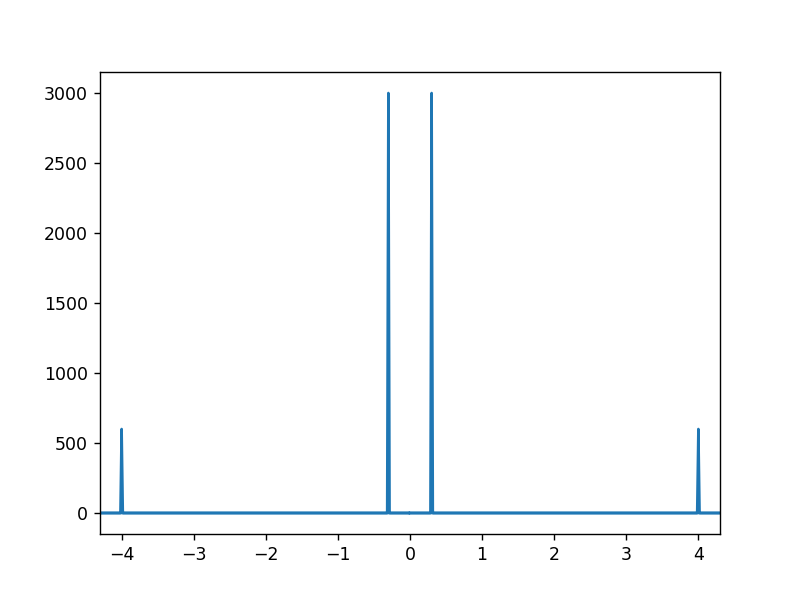

(-4.3, 4.3)

In [34]:
# Calculate spectra
Pxx = np.abs(np.fft.fft(s))
f = np.fft.fftfreq(len(s), dt)
plt.figure()
plt.plot(f, Pxx)
plt.xlim([-4.3, 4.3])

# We expect peaks at 0.3 and 4 Hz

<IPython.core.display.Javascript object>


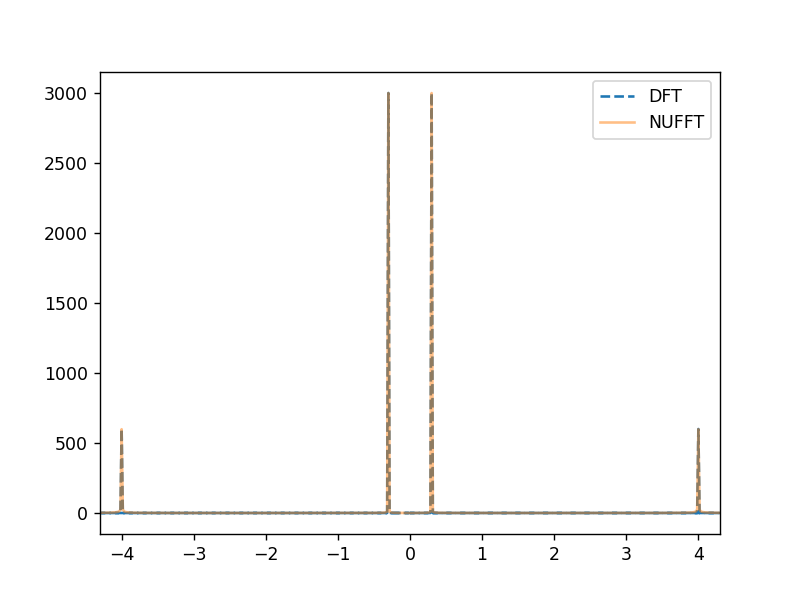

(-4.3, 4.3)

In [38]:
# Let's try and produce the same result using the uniform samples with the non-uniform FFT

# Rescale coordinates to interval [0, 2*np.pi]
xx = x / np.max(x) * 2*np.pi # x starts at zero, otherwise needs to be offset as well.

h = finufft.nufft1d1(xx, s.astype('complex128'), n_modes=len(s), isign=-1, eps=1e-6, upsampfac=1.25)

# Note: FINUFFT returns the output with lower frequencies at center (as opposed to numpy / DFT).
fh = np.fft.fftshift(f)

plt.figure()
plt.plot(f, Pxx, '--', label='DFT')
plt.plot(fh, np.abs(h), alpha=0.5, label='NUFFT')
plt.legend()
plt.xlim([-4.3, 4.3])

# Looks pretty good.

In [ ]:
# Now sample the function randomly
xr = np.random